In [1]:
import numpy as np
import pandas as pd
import os
import time
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data as data_utils
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split

from efficientnet_pytorch import EfficientNet

# For image-keypoints data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [2]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value) 
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars\n
        torch.backends.cudnn.deterministic = True  #needed\n
        torch.backends.cudnn.benchmark = False

seed = 42
random_seed(seed,True)

In [3]:
train_dir = os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","train_imgs")
num_classes = 48
batch_size = 64
num_epochs = 200
num_splits = 10
num_earlystop = 10
input_w_crop = 1080
input_h_crop = 1080
input_w_resize = 150
input_h_resize = 150
learning_rate = 0.01
feature_extract = False

In [4]:
df = pd.read_csv(os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","train_df.csv"))
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


In [5]:
imgs = df.iloc[:, 0].to_numpy()
motions = df.iloc[:, 1:]
columns = motions.columns.to_list()[::2]
class_labels = [label.replace('_x', '').replace('_y', '') for label in columns]
keypoints = []
for motion in motions.to_numpy():
    a_keypoints = []
    for i in range(0, motion.shape[0], 2):
        a_keypoints.append((float(motion[i]), float(motion[i+1])))
    keypoints.append(a_keypoints)
keypoints = np.array(keypoints)

In [6]:
def train_model(model, dataloaders, criterion, optimizer, earlystop=0, num_epochs=25, is_inception=False):
    since = time.time()
    
    val_acc_history = []
    val_loss_history = []
    earlystop_value = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    best_loss = 999999999
    
    for epoch in range(num_epochs):
        epoch_since = time.time()
        if earlystop and earlystop_value >= earlystop:
            break

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        #print('outputs.shape, aux_outputs shape : ', outputs.shape, aux_outputs.shape)
                        loss1 = criterion(outputs.float(), labels.float())
                        loss2 = criterion(aux_outputs.float(), labels.float())
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        #print('output shape : ', outputs.shape)
                        #print(outputs)
                        loss = criterion(outputs.float(), labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # for regression
                running_corrects += torch.sum(outputs == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_time_elapsed = time.time() - epoch_since
            print('{} ({}) Loss: {:.4f} Acc: {:.4f} Elapsed time: {:.0f}m {:.0f}s'.format(
                phase, len(dataloaders[phase].dataset), epoch_loss, epoch_acc, epoch_time_elapsed // 60, epoch_time_elapsed % 60))
#             neptune.log_metric(f'{phase}_loss', epoch_loss)
#             neptune.log_metric(f'{phase}_acc', epoch_acc)
            
            # deep copy the model
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    earlystop_value = 0
                else:
                    earlystop_value += 1
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training and Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'acc': val_acc_history, 'loss': val_loss_history}

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [8]:
model_name = 'efficientnet'
model_ver = 'b5'
def initialize_model(model_name, model_ver, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
#     model_ft = getattr(models, f'{model_name}{model_ver}')(pretrained=use_pretrained)
    model = EfficientNet.from_pretrained('efficientnet-b5')
    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, num_classes)
    #print(model)

    return model

# Initialize the model for this run
model_ft = initialize_model(model_name, model_ver, num_classes, feature_extract, use_pretrained=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Print the model we just instantiated
print(model_ft)

Loaded pretrained weights for efficientnet-b5
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2

In [9]:
A_transforms = {
    'train':
        A.Compose([
            #A.augmentations.CenterCrop(input_h_crop, input_w_crop, always_apply = True),
            A.Resize(input_h_resize, input_w_resize, always_apply=True),
            A.OneOf([A.HorizontalFlip(p=1),
                     A.RandomRotate90(p=1),
                     A.VerticalFlip(p=1)            
            ], p=0.5),
            A.augmentations.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True, angle_in_degrees=True)),
    
    'val':
        A.Compose([
            #A.augmentations.CenterCrop(input_h_crop, input_w_crop, always_apply = True),
            A.Resize(input_h_resize, input_w_resize, always_apply=True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True, angle_in_degrees=True)),
    
    'test':
        A.Compose([
            #A.augmentations.CenterCrop(input_h_crop, input_w_crop, always_apply = True),
            A.Resize(input_h_resize, input_w_resize, always_apply=True),
            #A.augmentations.CenterCrop(input_h, input_w, always_apply = True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
}

In [10]:
class Dataset(data_utils.Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, keypoints, phase, class_labels=None, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.keypoints = keypoints
        self.phase = phase
        self.class_labels = class_labels
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))
        keypoints = self.keypoints[idx]
    
        if self.data_transforms:
            augmented = self.data_transforms[self.phase](image=img, keypoints=keypoints, class_labels=self.class_labels)
            img = augmented['image']
            keypoints = augmented['keypoints']
        keypoints = np.array(keypoints).flatten()

        return img, keypoints
    
    def __len__(self):
        return len(self.imgs)

In [11]:
criterion = nn.MSELoss()

since = time.time()
X_train, X_val, y_train, y_val = train_test_split(imgs, keypoints, test_size=1/num_splits, random_state=42)
train_data = Dataset(train_dir, X_train, y_train, data_transforms=A_transforms, class_labels=class_labels, phase='train')
val_data = Dataset(train_dir, X_val, y_val, data_transforms=A_transforms, class_labels=class_labels, phase='val')
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(val_data, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Train and evaluate
model_ft, hists = train_model(
    model_ft, dataloaders, criterion, optimizer_ft,
    num_epochs=num_epochs,  is_inception=(model_name=="inception"))
weight_path = os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open", f"baseline_{model_name}_{model_ver}_0312.pth")
torch.save(model_ft.state_dict(), weight_path)
time_elapsed = time.time() - since
print('Elapsed time: {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/200
----------
train (3775) Loss: 1029.3379 Acc: 0.0000 Elapsed time: 1m 52s
val (420) Loss: 2791566420338.5903 Acc: 0.0000 Elapsed time: 2m 2s

Epoch 2/200
----------
train (3775) Loss: 287.3443 Acc: 0.0000 Elapsed time: 1m 48s
val (420) Loss: 3341.8122 Acc: 0.0000 Elapsed time: 1m 57s

Epoch 3/200
----------
train (3775) Loss: 281.3969 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 1120.8145 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 4/200
----------
train (3775) Loss: 197.3174 Acc: 0.0000 Elapsed time: 1m 49s
val (420) Loss: 327.9382 Acc: 0.0000 Elapsed time: 1m 58s

Epoch 5/200
----------
train (3775) Loss: 150.5113 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 309.8846 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 6/200
----------
train (3775) Loss: 108.9102 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 658.2343 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 7/200
----------
train (3775) Loss: 75.8436 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 607.1483 Acc: 0.0000 Elapsed ti

val (420) Loss: 254.8461 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 59/200
----------
train (3775) Loss: 25.9070 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 180.8850 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 60/200
----------
train (3775) Loss: 23.4361 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 56.5660 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 61/200
----------
train (3775) Loss: 27.1091 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 381.9173 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 62/200
----------
train (3775) Loss: 25.3400 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 117.1434 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 63/200
----------
train (3775) Loss: 26.1530 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 148.0341 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 64/200
----------
train (3775) Loss: 23.9159 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 296.7568 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 65/200
----------
train (3775) Loss: 24.0124 Acc: 0.0000 Elapsed time: 1m 47s


train (3775) Loss: 21.6289 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 221.7986 Acc: 0.0000 Elapsed time: 1m 57s

Epoch 117/200
----------
train (3775) Loss: 18.3476 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 97.1325 Acc: 0.0000 Elapsed time: 1m 57s

Epoch 118/200
----------
train (3775) Loss: 22.8314 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 108.3508 Acc: 0.0000 Elapsed time: 1m 57s

Epoch 119/200
----------
train (3775) Loss: 18.6671 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 56.5682 Acc: 0.0000 Elapsed time: 1m 57s

Epoch 120/200
----------
train (3775) Loss: 17.5402 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 100.5540 Acc: 0.0000 Elapsed time: 1m 57s

Epoch 121/200
----------
train (3775) Loss: 17.3893 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 48.4228 Acc: 0.0000 Elapsed time: 1m 57s

Epoch 122/200
----------
train (3775) Loss: 16.7989 Acc: 0.0000 Elapsed time: 1m 49s
val (420) Loss: 117.6697 Acc: 0.0000 Elapsed time: 1m 58s

Epoch 123/200
------

val (420) Loss: 16.6314 Acc: 0.0000 Elapsed time: 1m 57s

Epoch 174/200
----------
train (3775) Loss: 13.1994 Acc: 0.0003 Elapsed time: 1m 47s
val (420) Loss: 10.9717 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 175/200
----------
train (3775) Loss: 14.0300 Acc: 0.0000 Elapsed time: 1m 49s
val (420) Loss: 191.7811 Acc: 0.0000 Elapsed time: 1m 58s

Epoch 176/200
----------
train (3775) Loss: 14.1286 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 88.3020 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 177/200
----------
train (3775) Loss: 13.1051 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 20.4839 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 178/200
----------
train (3775) Loss: 12.7973 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 28.1324 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 179/200
----------
train (3775) Loss: 12.2519 Acc: 0.0000 Elapsed time: 1m 47s
val (420) Loss: 16.8719 Acc: 0.0000 Elapsed time: 1m 56s

Epoch 180/200
----------
train (3775) Loss: 13.3424 Acc: 0.0000 Elapsed time: 1m 47

In [12]:
print(len(train_data), len(val_data))

3775 420


<class 'list'>


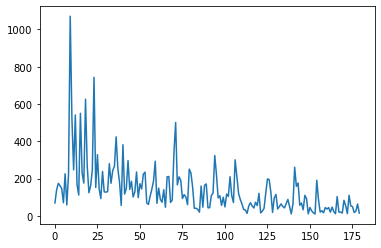

In [21]:
import matplotlib.pyplot as plt
print(type(hists['loss']))
losses = np.array([])

for loss in hists['loss']:
    losses = np.append(losses, loss)

plt.plot(losses[20:])
plt.show()
#200 epoch 6hours 

In [14]:
model_ft.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [15]:
# test_dir = f'{prefix}/data/test_imgs'
test_dir = os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","test_imgs")
test_imgs = os.listdir(test_dir)

In [16]:
class TestDataset(data_utils.Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, phase, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.phase = phase
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))

        if self.data_transforms:
            augmented = self.data_transforms[self.phase](image=img)
            img = augmented['image']
        return filename, img
    
    def __len__(self):
        return len(self.imgs)
    
test_data = TestDataset(test_dir, test_imgs, data_transforms=A_transforms, phase='test')
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [17]:
all_predictions = []
files = []
with torch.no_grad():
    for filenames, inputs in test_loader:
        predictions = list(model_ft(inputs.to(device)).cpu().numpy())
        files.extend(filenames)
        for prediction in predictions:
            all_predictions.append(prediction)

In [18]:
all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(num_classes//2)]] /= input_w_resize / 1920
    all_predictions[i, [2*j + 1 for j in range(num_classes//2)]] /= input_h_resize / 1080

In [19]:
path = os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","sample_submission.csv")
df_sub = pd.read_csv(path)
df = pd.DataFrame(columns=df_sub.columns)
df['image'] = files
df.iloc[:, 1:] = all_predictions
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1117.597656,530.090637,1123.552246,548.380798,1145.809082,542.808594,1103.622681,585.301086,1155.160889,...,1078.468872,313.608185,975.882202,557.902832,893.33905,550.480957,665.916565,700.954895,764.800659,664.596436
1,649-2-4-32-Z148_A-0000003.jpg,1116.693604,530.937134,1122.715088,549.403687,1144.859619,543.786682,1102.488403,586.51355,1153.810303,...,1078.83374,313.711639,974.37439,558.418213,891.998413,550.734314,667.139282,700.570068,765.568665,663.787231
2,649-2-4-32-Z148_A-0000005.jpg,1123.157959,540.511292,1132.065308,561.278931,1152.297607,555.952454,1111.440186,598.858459,1159.699219,...,1105.588867,283.618103,975.273071,559.171997,889.923523,547.340088,679.25177,697.950745,772.860474,657.198547
3,649-2-4-32-Z148_A-0000007.jpg,1193.003906,573.79657,1206.830811,587.262634,1235.377197,578.070679,1172.275635,620.953491,1238.105225,...,1328.338135,539.834351,1003.806641,578.470276,905.018921,568.476013,625.768005,690.792542,768.779297,647.536316
4,649-2-4-32-Z148_A-0000009.jpg,1136.396851,534.157043,1146.82373,558.716797,1169.981812,555.397583,1125.701172,600.335022,1180.824585,...,1141.395508,295.080475,981.003113,553.145996,889.610352,543.965881,665.572083,693.052429,777.77533,656.896118


In [20]:
df.to_csv(os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","efficient_crop.csv"), index=False)